In [1]:
import decoupler as dc
import os, sys
# Only needed for visualization:
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import anndata as ad
from scipy.stats import ttest_ind as tt
import numpy as np

In [2]:
pathway_file = ['deg_200/K562_fc/K562_bottom_200_fc.gmt', 'deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt',
               'deg_200/K562_edgeR_DE/DE_bottom_200.gmt', 'deg_200/K562_DE/DE_top_200.gmt']

In [3]:
msigdb = dc.get_resource('MSigDB')

# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]
msigdb


,genesymbol,collection,geneset
233,MAFF,hallmark,HALLMARK_IL2_STAT5_SIGNALING
250,MAFF,hallmark,HALLMARK_COAGULATION
270,MAFF,hallmark,HALLMARK_HYPOXIA
373,MAFF,hallmark,HALLMARK_TNFA_SIGNALING_VIA_NFKB
377,MAFF,hallmark,HALLMARK_COMPLEMENT
...,...,...,...
1449668,STXBP1,hallmark,HALLMARK_PANCREAS_BETA_CELLS
1450315,ELP4,hallmark,HALLMARK_PANCREAS_BETA_CELLS
1450526,GCG,hallmark,HALLMARK_PANCREAS_BETA_CELLS
1450731,PCSK2,hallmark,HALLMARK_PANCREAS_BETA_CELLS


In [4]:
name_conversion_file = pd.read_csv('ensemble_to_refseq.txt', delimiter='\t', header=None, index_col=0)
name_conversion_file

,1
0,
ENSG00000000003.10,TSPAN6
ENSG00000000419.8,DPM1
ENSG00000000457.9,SCYL3
ENSG00000000460.12,C1orf112
ENSG00000000971.11,CFH
...,...
ENSG00000273483.1,None
ENSG00000273485.1,None
ENSG00000273486.1,None


In [5]:
conversion_dict = name_conversion_file.to_dict()[1]
conversion_dict

{'ENSG00000000003.10': 'TSPAN6',
 'ENSG00000000419.8': 'DPM1',
 'ENSG00000000457.9': 'SCYL3',
 'ENSG00000000460.12': 'C1orf112',
 'ENSG00000000971.11': 'CFH',
 'ENSG00000001036.9': 'FUCA2',
 'ENSG00000001084.6': 'GCLC',
 'ENSG00000001167.10': 'NFYA',
 'ENSG00000001460.13': 'STPG1',
 'ENSG00000001461.12': 'NIPAL3',
 'ENSG00000001497.12': 'LAS1L',
 'ENSG00000001561.6': 'ENPP4',
 'ENSG00000001617.7': 'SEMA3F',
 'ENSG00000001629.5': 'ANKIB1',
 'ENSG00000001630.11': 'CYP51A1',
 'ENSG00000001631.10': 'None',
 'ENSG00000002016.12': 'RAD52',
 'ENSG00000002079.8': 'None',
 'ENSG00000002330.9': 'BAD',
 'ENSG00000002549.8': 'LAP3',
 'ENSG00000002586.13': 'CD99',
 'ENSG00000002746.10': 'HECW1',
 'ENSG00000002822.11': 'MAD1L1',
 'ENSG00000002834.13': 'LASP1',
 'ENSG00000002919.10': 'SNX11',
 'ENSG00000003056.3': 'M6PR',
 'ENSG00000003096.9': 'KLHL13',
 'ENSG00000003137.4': 'CYP26B1',
 'ENSG00000003147.13': 'ICA1',
 'ENSG00000003249.9': 'DBNDD1',
 'ENSG00000003393.10': 'ALS2',
 'ENSG00000003400.10':

In [6]:
# format pathway file
pathway_dfs = dict()
for f in pathway_file:
    symbol_list = []
    collection_list = []
    geneset_list = []
    file = open(f, 'r')
    info = file.readlines()
    for line in info:
        line = line.strip().split('\t')
        for gene in line[2:]:
            symbol_list.append(gene)
            collection_list.append('custom')
            geneset_list.append(line[0])
    pathway_df = pd.DataFrame()
    pathway_df['genesymbol'] = symbol_list
    pathway_df['collection'] = collection_list
    pathway_df['geneset'] = geneset_list
    pathway_dfs[f] = pathway_df
    file.close()

In [7]:
pathway_dfs['deg_200/K562_fc/K562_bottom_200_fc.gmt']

,genesymbol,collection,geneset
0,ENSG00000206878.1,custom,NOL12
1,ENSG00000224365.1,custom,NOL12
2,ENSG00000238622.1,custom,NOL12
3,ENSG00000255072.1,custom,NOL12
4,ENSG00000200320.1,custom,NOL12
...,...,...,...
39395,ENSG00000110013.8,custom,RBM22
39396,ENSG00000145020.10,custom,RBM22
39397,ENSG00000139269.2,custom,RBM22
39398,ENSG00000181192.7,custom,RBM22


In [9]:
expr_dir = '/Volumes/Luopin_8T_2/GSEA_test/ENCODE_RNA-seq/deg_200/HepG2_DE_prerank/'
all_expr_file = os.listdir(expr_dir)
all_expr_file.sort()
result_dict = dict()
for f in all_expr_file:
    if f.endswith('rnk'):
        print(f)
        target = f.split('.')[0]
        result_dict[target] = dict()
        data = pd.read_csv(expr_dir+f, delimiter='\t', index_col=0, header=None)
        # data = data.drop(columns=['DESCRIPTION'])
        """
        new_names = []
        for n in data.index:
            new_names.append(name_conversion_file.loc[n][1])

        
        data.index = new_names
        data = data.loc[data.index != 'None']
        """
        adata = ad.AnnData(data)
        adata = adata.transpose()
        adata
        # break3
        for df in pathway_dfs.keys():
            results = dc.run_consensus(mat=adata, net=pathway_dfs[df], source='geneset',
                                  target='genesymbol', weight=None, verbose=False, use_raw=False)
            result_dict[target][df] = adata.obsm['consensus_estimate'].transpose()
            print(df, np.where(adata.obsm['consensus_estimate'].transpose().sort_values(by='1', ascending=False).index==target)[0][0]+1)
        
        # break

AARS.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 2
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 23
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 3
deg_200/K562_DE/DE_top_200.gmt 1
AATF.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 10
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 22
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 5
deg_200/K562_DE/DE_top_200.gmt 2
ABCF1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 41
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 13
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 14
deg_200/K562_DE/DE_top_200.gmt 13
ADAR.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 2
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 6
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
AGO1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 2
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 2
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 2
deg_200/K562_DE/DE_top_200.gmt 2
AKAP1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 36
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 40
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 7
deg_200/K562_DE/DE_top_200.gmt 2
AKAP8.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 90
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 49
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 103
deg_200/K562_DE/DE_top_200.gmt 5
AKAP8L.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 20
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 93
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 13
deg_200/K562_DE/DE_top_200.gmt 1
APOBEC3C.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 42
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 116
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 42
deg_200/K562_DE/DE_top_200.gmt 24
ASCC1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 11
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 43
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
ATP5C1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 52
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 19
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 91
deg_200/K562_DE/DE_top_200.gmt 1
AUH.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 116
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
BCCIP.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 6
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
BCLAF1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 21
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 6
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 9
deg_200/K562_DE/DE_top_200.gmt 1
BOP1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 1
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
BUD13.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 8
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 4
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 7
deg_200/K562_DE/DE_top_200.gmt 3
CCAR1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 8
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 14
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 3
deg_200/K562_DE/DE_top_200.gmt 1
CCAR2.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 5
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 14
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
CELF1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 2
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 54
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
CIRBP.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 1
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
CKAP4.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 5
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 30
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 3
deg_200/K562_DE/DE_top_200.gmt 11
CNOT7.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 2
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 3
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 2
deg_200/K562_DE/DE_top_200.gmt 1
CPSF6.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 1
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
CPSF7.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 98
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 128
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 97
deg_200/K562_DE/DE_top_200.gmt 161
CSTF2.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 84
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 56
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 29
deg_200/K562_DE/DE_top_200.gmt 69
CSTF2T.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 2
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 19
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 2
DAZAP1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 16
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 7
deg_200/K562_DE/DE_top_200.gmt 6
DDX1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 3
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
DDX19B.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 39
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
DDX24.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 16
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 78
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
DDX27.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 1
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
DDX28.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 12
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 45
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
DDX3X.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 1
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
DDX47.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 154
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 180
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 21
deg_200/K562_DE/DE_top_200.gmt 59
DDX52.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 19
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
DDX55.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 3
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 8
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 2
deg_200/K562_DE/DE_top_200.gmt 98
DDX6.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 4
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 23
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
DHX30.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 165
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 127
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 67
deg_200/K562_DE/DE_top_200.gmt 42
DKC1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 141
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 106
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 176
deg_200/K562_DE/DE_top_200.gmt 29
DNAJC2.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 7
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 4
DNAJC21.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 48
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 89
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 20
deg_200/K562_DE/DE_top_200.gmt 1
EEF2.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 12
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 21
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 2
deg_200/K562_DE/DE_top_200.gmt 7
EFTUD2.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 3
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 4
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
EIF2S1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 3
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
EIF2S2.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 8
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 16
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 7
deg_200/K562_DE/DE_top_200.gmt 13
EIF3D.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 3
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
EIF3G.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 15
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
EIF4A3.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 9
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 26
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 3
deg_200/K562_DE/DE_top_200.gmt 4
EIF4B.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 2
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
EIF4G1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 3
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 14
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
EIF4G2.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 14
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 38
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 39
deg_200/K562_DE/DE_top_200.gmt 4
ESF1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 181
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 22
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 16
deg_200/K562_DE/DE_top_200.gmt 38
EWSR1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 86
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 165
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 32
deg_200/K562_DE/DE_top_200.gmt 70
EXOSC9.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 69
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 63
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 140
deg_200/K562_DE/DE_top_200.gmt 58
FAM120A.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 1
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 5
FASTKD2.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 4
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
FIP1L1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 17
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 7
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 19
deg_200/K562_DE/DE_top_200.gmt 1
FKBP4.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 6
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 54
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 8
deg_200/K562_DE/DE_top_200.gmt 15
FMR1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 96
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 143
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 97
deg_200/K562_DE/DE_top_200.gmt 149
FTO.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 2
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 2
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
FUBP3.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 68
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 131
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 19
deg_200/K562_DE/DE_top_200.gmt 38
FUS.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 10
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 28
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 2
deg_200/K562_DE/DE_top_200.gmt 1
FXR1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 14
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 10
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 17
deg_200/K562_DE/DE_top_200.gmt 5
G3BP1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 4
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 24
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
G3BP2.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 27
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 23
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 63
deg_200/K562_DE/DE_top_200.gmt 1
GEMIN5.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 11
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 1
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
GPKOW.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 2
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
GRSF1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 10
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 2
deg_200/K562_DE/DE_top_200.gmt 1
GRWD1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 59
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 70
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 10
deg_200/K562_DE/DE_top_200.gmt 1
GTF2F1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 9
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
HLTF.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 9
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 72
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 13
deg_200/K562_DE/DE_top_200.gmt 15
HNRNPA0.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 2
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 5
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
HNRNPA1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 7
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
HNRNPA2B1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 28
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 55
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 105
deg_200/K562_DE/DE_top_200.gmt 117
HNRNPAB.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 2
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 3
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
HNRNPC.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 1
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
HNRNPK.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 2
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
HNRNPL.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 1
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
HNRNPM.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 6
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 24
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 2
deg_200/K562_DE/DE_top_200.gmt 2
HNRNPU.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 1
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
HNRNPUL1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 3
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
HSPD1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 7
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
IGF2BP2.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 2
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
IGF2BP3.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 26
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 62
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
ILF2.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 1
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
ILF3.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 2
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
KHDRBS1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 2
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 2
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
KHSRP.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 1
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
KIF1C.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 4
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 1
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 26
deg_200/K562_DE/DE_top_200.gmt 1
KRR1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 17
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 14
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 16
deg_200/K562_DE/DE_top_200.gmt 40
LARP4.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 2
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 2
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
LARP7.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 22
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 25
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 36
deg_200/K562_DE/DE_top_200.gmt 13
LIN28B.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 8
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 2
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 2
deg_200/K562_DE/DE_top_200.gmt 1
LSM11.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 47
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 30
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 44
deg_200/K562_DE/DE_top_200.gmt 13
MAGOH.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 6
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 60
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 2
MATR3.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 1
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
METAP2.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 24
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 43
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 53
deg_200/K562_DE/DE_top_200.gmt 95
MSI2.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 13
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 120
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 31
deg_200/K562_DE/DE_top_200.gmt 26
MTPAP.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 149
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 195
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 34
deg_200/K562_DE/DE_top_200.gmt 9
NAA15.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 15
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 2
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 114
deg_200/K562_DE/DE_top_200.gmt 3
NCBP2.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 126
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 55
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 5
deg_200/K562_DE/DE_top_200.gmt 1
NELFE.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 5
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
NOL12.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 4
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
NONO.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 1
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
NPM1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 8
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 7
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 46
deg_200/K562_DE/DE_top_200.gmt 6
NSUN2.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 33
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
NUFIP2.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 197
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 138
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 161
deg_200/K562_DE/DE_top_200.gmt 115
NUSAP1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 1
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 2
deg_200/K562_DE/DE_top_200.gmt 1
PA2G4.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 30
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 5
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 45
deg_200/K562_DE/DE_top_200.gmt 8
PABPC1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 4
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
PABPC4.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 2
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 16
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
PARN.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 7
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 32
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 2
deg_200/K562_DE/DE_top_200.gmt 19
PCBP1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 15
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 20
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
PCBP2.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 2
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
PES1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 108
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 74
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 56
deg_200/K562_DE/DE_top_200.gmt 14
PHF6.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 55
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 4
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 2
deg_200/K562_DE/DE_top_200.gmt 6
PKM.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 53
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 3
deg_200/K562_DE/DE_top_200.gmt 4
PNPT1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 1
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
PPIG.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 2
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 2
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 2
deg_200/K562_DE/DE_top_200.gmt 1
PPIL4.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 12
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 105
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 48
deg_200/K562_DE/DE_top_200.gmt 1
PRPF6.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 6
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
PRPF8.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 2
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 4
deg_200/K562_DE/DE_top_200.gmt 6
PSIP1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 1
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
PTBP1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 1
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
PUF60.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 5
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
PUM1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 9
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 33
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 4
deg_200/K562_DE/DE_top_200.gmt 1
PUM2.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 2
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 10
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
PUS1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 19
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 38
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 54
deg_200/K562_DE/DE_top_200.gmt 1
QKI.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 23
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
RAVER1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 2
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 6
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
RBFOX2.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 24
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 12
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 30
deg_200/K562_DE/DE_top_200.gmt 20
RBM15.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 120
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 107
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 179
deg_200/K562_DE/DE_top_200.gmt 38
RBM17.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 14
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 38
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 10
deg_200/K562_DE/DE_top_200.gmt 1
RBM22.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 7
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 13
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 12
deg_200/K562_DE/DE_top_200.gmt 19
RBM25.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 2
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 2
deg_200/K562_DE/DE_top_200.gmt 2
RBM34.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 43
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 72
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 183
deg_200/K562_DE/DE_top_200.gmt 78
RBM39.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 36
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 22
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 16
deg_200/K562_DE/DE_top_200.gmt 2
RCC2.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 1
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
RECQL.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 19
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 50
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 9
deg_200/K562_DE/DE_top_200.gmt 1
RPS10.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 6
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 2
deg_200/K562_DE/DE_top_200.gmt 2
RPS19.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 19
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 12
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 5
deg_200/K562_DE/DE_top_200.gmt 4
RPS3A.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 2
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 21
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 11
deg_200/K562_DE/DE_top_200.gmt 12
RRP9.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 15
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 9
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 22
deg_200/K562_DE/DE_top_200.gmt 35
RTF1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 2
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
SAFB2.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 2
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 4
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 15
SART3.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 1
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
SBDS.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 5
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 1
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 11
deg_200/K562_DE/DE_top_200.gmt 1
SERBP1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 1
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
SF1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 13
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 38
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 15
deg_200/K562_DE/DE_top_200.gmt 5
SF3A3.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 7
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 13
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 4
deg_200/K562_DE/DE_top_200.gmt 3
SF3B1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 12
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
SF3B4.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 4
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
SFPQ.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 13
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 18
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 2
deg_200/K562_DE/DE_top_200.gmt 1
SLBP.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 2
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 5
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 4
deg_200/K562_DE/DE_top_200.gmt 2
SLTM.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 3
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
SMN1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 4
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 31
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 2
deg_200/K562_DE/DE_top_200.gmt 1
SMNDC1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 14
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 14
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 2
deg_200/K562_DE/DE_top_200.gmt 1
SND1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 82
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 31
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 161
deg_200/K562_DE/DE_top_200.gmt 129
SNRNP200.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 31
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 96
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 119
deg_200/K562_DE/DE_top_200.gmt 8
SRFBP1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 163
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 116
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 129
deg_200/K562_DE/DE_top_200.gmt 55
SRP68.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 2
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 8
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
SRSF1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 10
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 12
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 8
deg_200/K562_DE/DE_top_200.gmt 2
SRSF5.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 28
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 60
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 20
deg_200/K562_DE/DE_top_200.gmt 81
SSB.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 21
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 42
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 29
deg_200/K562_DE/DE_top_200.gmt 10
SSRP1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 27
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 14
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 27
deg_200/K562_DE/DE_top_200.gmt 39
STAU1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 24
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 75
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 12
deg_200/K562_DE/DE_top_200.gmt 7
STIP1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 1
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
SUB1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 15
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 15
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
SUCLG1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 2
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 6
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 2
deg_200/K562_DE/DE_top_200.gmt 1
SUGP2.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 33
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 21
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 39
deg_200/K562_DE/DE_top_200.gmt 9
SUPT6H.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 63
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 60
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 151
deg_200/K562_DE/DE_top_200.gmt 72
SUPV3L1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 1
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 3
deg_200/K562_DE/DE_top_200.gmt 3
TAF15.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 4
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 4
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 5
deg_200/K562_DE/DE_top_200.gmt 31
TARDBP.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 7
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 5
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 23
deg_200/K562_DE/DE_top_200.gmt 36
TBRG4.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 104
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 57
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 76
deg_200/K562_DE/DE_top_200.gmt 80
TFIP11.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 10
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 4
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 10
deg_200/K562_DE/DE_top_200.gmt 15
TIA1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 107
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 80
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 6
deg_200/K562_DE/DE_top_200.gmt 1
TIAL1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 1
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 2
deg_200/K562_DE/DE_top_200.gmt 3
TRA2A.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 17
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 104
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 2
TRIM56.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 2
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
TROVE2.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 68
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 174
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 57
deg_200/K562_DE/DE_top_200.gmt 179
TUFM.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 2
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 3
U2AF1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 7
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 34
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 5
deg_200/K562_DE/DE_top_200.gmt 10
U2AF2.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 2
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 2
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 7
deg_200/K562_DE/DE_top_200.gmt 1
UBE2L3.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 2
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 4
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
UCHL5.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 6
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 9
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 12
deg_200/K562_DE/DE_top_200.gmt 4
UPF1.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 176
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 195
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 172
deg_200/K562_DE/DE_top_200.gmt 51
UPF2.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 2
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 43
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
UTP18.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 26
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 37
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 6
deg_200/K562_DE/DE_top_200.gmt 5
UTP3.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 97
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 122
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 126
deg_200/K562_DE/DE_top_200.gmt 50
XPO5.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 17
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 11
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 38
deg_200/K562_DE/DE_top_200.gmt 39
XRCC5.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 7
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 2
XRCC6.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 19
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 29
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 3
deg_200/K562_DE/DE_top_200.gmt 1
XRN2.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 8
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 8
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 7
deg_200/K562_DE/DE_top_200.gmt 3
YBX3.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 1
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 4
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 1
deg_200/K562_DE/DE_top_200.gmt 1
ZC3H8.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 14
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 8
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 43
deg_200/K562_DE/DE_top_200.gmt 54
ZRANB2.rnk


/var/folders/0t/zkf9kjwx2dl0_jdt25xk6l100000gn/T/ipykernel_31436/417767036.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)
/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


deg_200/K562_fc/K562_bottom_200_fc.gmt 50
deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt 73
deg_200/K562_edgeR_DE/DE_bottom_200.gmt 4
deg_200/K562_DE/DE_top_200.gmt 2


In [ ]:
adata.obsm['consensus_estimate'].transpose().sort_values(by='1', ascending=False)

In [66]:
def apk(predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average precision at k between two lists of items.
    """
    total_num = len(predicted)
    precision_list = []
    for idx in range(k):
        precision_list.append(np.where(predicted<=idx+1)[0].shape[0]/total_num)
        print(np.where(predicted<=idx+1)[0].shape[0])
    return np.mean(precision_list)

In [33]:
target

'ZRANB2'

In [10]:
from scipy.stats import rankdata as rnk

In [11]:
deseq_rank = []
for t in rank_dict.keys():
    deseq_rank.append(rank_dict[t]['deg_200/K562_DE/DE_top_200.gmt'])

NameError: name 'rank_dict' is not defined

In [76]:
150/len(rank_dict.keys())

0.7614213197969543

In [74]:
apk(np.array(deseq_rank))

106
120
127
133
138
142
144
146
148
150


0.6873096446700508

In [68]:
deseq_rank = []
for t in rank_dict.keys():
    deseq_rank.append(rank_dict[t]['deg_200/K562_edgeR_DE/DE_bottom_200.gmt'])

In [69]:
apk(np.array(deseq_rank))

84
103
110
115
120
122
128
130
132
135


0.5984771573604061

In [12]:
rank_dict = dict()
for target in result_dict.keys():
    rank_dict[target] = dict()
    for pathway in result_dict[target]:
        tmp_df = result_dict[target][pathway]
        tmp_df['1'] = tmp_df['1']*(-1)
        # break
        ranks = rnk(tmp_df['1'])
        rank = ranks[np.argwhere(tmp_df.index==target)[0, 0]]
        print(target, rank, pathway)
        rank_dict[target][pathway] = rank

AARS 2.0 deg_200/K562_fc/K562_bottom_200_fc.gmt
AARS 23.0 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
AARS 3.0 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
AARS 1.0 deg_200/K562_DE/DE_top_200.gmt
AATF 10.0 deg_200/K562_fc/K562_bottom_200_fc.gmt
AATF 22.0 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
AATF 5.0 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
AATF 2.0 deg_200/K562_DE/DE_top_200.gmt
ABCF1 41.0 deg_200/K562_fc/K562_bottom_200_fc.gmt
ABCF1 13.0 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
ABCF1 14.0 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
ABCF1 13.0 deg_200/K562_DE/DE_top_200.gmt
ADAR 2.0 deg_200/K562_fc/K562_bottom_200_fc.gmt
ADAR 6.0 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
ADAR 1.0 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
ADAR 1.0 deg_200/K562_DE/DE_top_200.gmt
AGO1 2.0 deg_200/K562_fc/K562_bottom_200_fc.gmt
AGO1 2.0 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
AGO1 2.0 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
AGO1 2.0 deg_200/K562_DE/DE_top_200.gmt
AKAP

RPS3A 11.0 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
RPS3A 12.0 deg_200/K562_DE/DE_top_200.gmt
RRP9 15.0 deg_200/K562_fc/K562_bottom_200_fc.gmt
RRP9 9.0 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
RRP9 22.0 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
RRP9 35.0 deg_200/K562_DE/DE_top_200.gmt
RTF1 1.0 deg_200/K562_fc/K562_bottom_200_fc.gmt
RTF1 2.0 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
RTF1 1.0 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
RTF1 1.0 deg_200/K562_DE/DE_top_200.gmt
SAFB2 2.0 deg_200/K562_fc/K562_bottom_200_fc.gmt
SAFB2 4.0 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
SAFB2 1.0 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
SAFB2 15.0 deg_200/K562_DE/DE_top_200.gmt
SART3 1.0 deg_200/K562_fc/K562_bottom_200_fc.gmt
SART3 1.0 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
SART3 1.0 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
SART3 1.0 deg_200/K562_DE/DE_top_200.gmt
SBDS 5.0 deg_200/K562_fc/K562_bottom_200_fc.gmt
SBDS 1.0 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt

<AxesSubplot: >

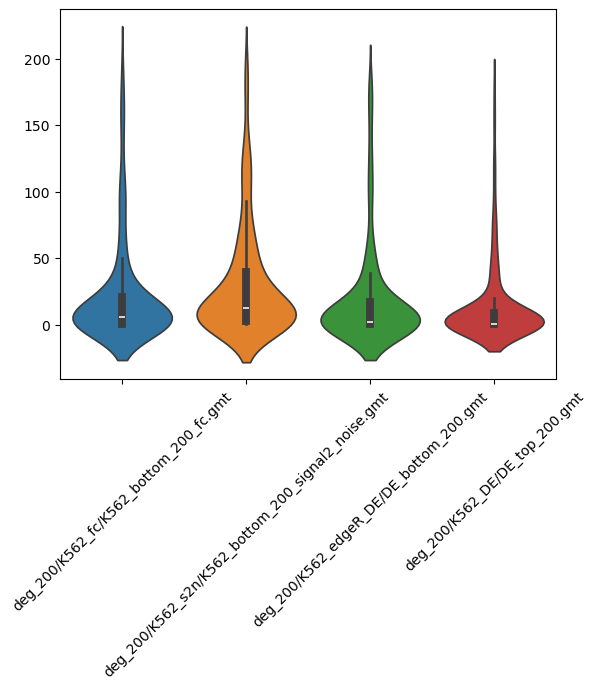

In [13]:
rank_df = pd.DataFrame.from_dict(rank_dict)
plt.xticks(rotation=45)
sns.violinplot(data=rank_df.transpose())

In [14]:
rank_df.transpose().to_csv('decoupler_results.contrast.txt', sep='\t')

In [16]:
! open decoupler_results.contrast.txt

In [49]:
rank_dict = dict()
for target in result_dict.keys():
    rank_dict[target] = dict()
    for pathway in result_dict[target]:
        tmp_df = result_dict[target][pathway]
        tmp_list = []
        for p in tmp_df.columns:
            col = tmp_df[p]
            # fc = (tmp_df.iloc[0]+tmp_df.iloc[1])/(tmp_df.iloc[2]+tmp_df.iloc[3])
            # fc = fc.sort_values()
            diff =col[0] + col[1] - col[2] - col[3]
            tmp_list.append([p, diff])
        tmp_list.sort(key = lambda x: x[1])
        tmp_list.reverse()
        rank = 1
        for t in tmp_list:
            if t[0] == target:
                break
            else:
                rank += 1
        print(target, rank, pathway)
        rank_dict[target][pathway] = rank

AARS 50 deg_200/K562_fc/K562_bottom_200_fc.gmt
AARS 31 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
AARS 81 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
AARS 39 deg_200/K562_DE/DE_top_200.gmt
AATF 90 deg_200/K562_fc/K562_bottom_200_fc.gmt
AATF 24 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
AATF 31 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
AATF 19 deg_200/K562_DE/DE_top_200.gmt
ABCF1 23 deg_200/K562_fc/K562_bottom_200_fc.gmt
ABCF1 38 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
ABCF1 11 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
ABCF1 118 deg_200/K562_DE/DE_top_200.gmt
ADAR 11 deg_200/K562_fc/K562_bottom_200_fc.gmt
ADAR 22 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
ADAR 22 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
ADAR 44 deg_200/K562_DE/DE_top_200.gmt
AGO1 54 deg_200/K562_fc/K562_bottom_200_fc.gmt
AGO1 73 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
AGO1 84 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
AGO1 32 deg_200/K562_DE/DE_top_200.gmt
AKAP1 92 deg_200/K562_fc/K562_

ESF1 47 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
ESF1 14 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
ESF1 191 deg_200/K562_DE/DE_top_200.gmt
EWSR1 153 deg_200/K562_fc/K562_bottom_200_fc.gmt
EWSR1 80 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
EWSR1 118 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
EWSR1 118 deg_200/K562_DE/DE_top_200.gmt
EXOSC9 182 deg_200/K562_fc/K562_bottom_200_fc.gmt
EXOSC9 174 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
EXOSC9 189 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
EXOSC9 181 deg_200/K562_DE/DE_top_200.gmt
FAM120A 1 deg_200/K562_fc/K562_bottom_200_fc.gmt
FAM120A 1 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
FAM120A 29 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
FAM120A 18 deg_200/K562_DE/DE_top_200.gmt
FASTKD2 76 deg_200/K562_fc/K562_bottom_200_fc.gmt
FASTKD2 66 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
FASTKD2 3 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
FASTKD2 3 deg_200/K562_DE/DE_top_200.gmt
FIP1L1 124 deg_200/K562_fc/K562_bottom_200

PUF60 2 deg_200/K562_DE/DE_top_200.gmt
PUM1 40 deg_200/K562_fc/K562_bottom_200_fc.gmt
PUM1 39 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
PUM1 40 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
PUM1 32 deg_200/K562_DE/DE_top_200.gmt
PUM2 22 deg_200/K562_fc/K562_bottom_200_fc.gmt
PUM2 187 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
PUM2 25 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
PUM2 26 deg_200/K562_DE/DE_top_200.gmt
PUS1 114 deg_200/K562_fc/K562_bottom_200_fc.gmt
PUS1 145 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
PUS1 137 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
PUS1 171 deg_200/K562_DE/DE_top_200.gmt
QKI 113 deg_200/K562_fc/K562_bottom_200_fc.gmt
QKI 133 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
QKI 14 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
QKI 128 deg_200/K562_DE/DE_top_200.gmt
RAVER1 31 deg_200/K562_fc/K562_bottom_200_fc.gmt
RAVER1 42 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
RAVER1 21 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
RAVER1 25 deg_200/K562_DE

/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

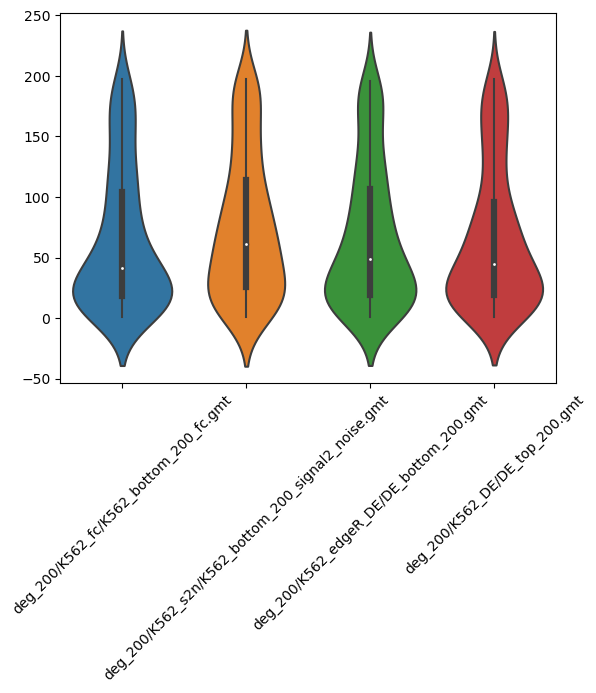

In [50]:
rank_df = pd.DataFrame.from_dict(rank_dict)
rank_df.transpose().to_csv('decoupler_results.diff.txt', sep='\t')
plt.xticks(rotation=45)
sns.violinplot(data=rank_df.transpose())

In [52]:
rank_dict = dict()
for target in result_dict.keys():
    rank_dict[target] = dict()
    for pathway in result_dict[target]:
        tmp_df = result_dict[target][pathway]
        tmp_list = []
        for p in tmp_df.columns:
            col = tmp_df[p]
            # fc = (tmp_df.iloc[0]+tmp_df.iloc[1])/(tmp_df.iloc[2]+tmp_df.iloc[3])
            # fc = fc.sort_values()
            diff =col[0] + col[1]
            tmp_list.append([p, diff])
        tmp_list.sort(key = lambda x: x[1])
        tmp_list.reverse()
        rank = 1
        for t in tmp_list:
            if t[0] == target:
                break
            else:
                rank += 1
        print(target, rank, pathway)
        rank_dict[target][pathway] = rank

AARS 21 deg_200/K562_fc/K562_bottom_200_fc.gmt
AARS 22 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
AARS 17 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
AARS 38 deg_200/K562_DE/DE_top_200.gmt
AATF 66 deg_200/K562_fc/K562_bottom_200_fc.gmt
AATF 34 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
AATF 153 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
AATF 133 deg_200/K562_DE/DE_top_200.gmt
ABCF1 108 deg_200/K562_fc/K562_bottom_200_fc.gmt
ABCF1 69 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
ABCF1 20 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
ABCF1 68 deg_200/K562_DE/DE_top_200.gmt
ADAR 29 deg_200/K562_fc/K562_bottom_200_fc.gmt
ADAR 18 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
ADAR 133 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
ADAR 71 deg_200/K562_DE/DE_top_200.gmt
AGO1 186 deg_200/K562_fc/K562_bottom_200_fc.gmt
AGO1 109 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
AGO1 125 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
AGO1 197 deg_200/K562_DE/DE_top_200.gmt
AKAP1 160 deg_200/K562_

HNRNPL 35 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
HNRNPL 47 deg_200/K562_DE/DE_top_200.gmt
HNRNPM 132 deg_200/K562_fc/K562_bottom_200_fc.gmt
HNRNPM 142 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
HNRNPM 177 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
HNRNPM 31 deg_200/K562_DE/DE_top_200.gmt
HNRNPU 13 deg_200/K562_fc/K562_bottom_200_fc.gmt
HNRNPU 70 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
HNRNPU 164 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
HNRNPU 82 deg_200/K562_DE/DE_top_200.gmt
HNRNPUL1 56 deg_200/K562_fc/K562_bottom_200_fc.gmt
HNRNPUL1 98 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
HNRNPUL1 124 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
HNRNPUL1 20 deg_200/K562_DE/DE_top_200.gmt
HSPD1 6 deg_200/K562_fc/K562_bottom_200_fc.gmt
HSPD1 119 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
HSPD1 8 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
HSPD1 194 deg_200/K562_DE/DE_top_200.gmt
IGF2BP2 112 deg_200/K562_fc/K562_bottom_200_fc.gmt
IGF2BP2 136 deg_200/K562_s2n/K562_bottom_200_

RBM15 3 deg_200/K562_DE/DE_top_200.gmt
RBM17 192 deg_200/K562_fc/K562_bottom_200_fc.gmt
RBM17 186 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
RBM17 57 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
RBM17 97 deg_200/K562_DE/DE_top_200.gmt
RBM22 130 deg_200/K562_fc/K562_bottom_200_fc.gmt
RBM22 121 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
RBM22 113 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
RBM22 74 deg_200/K562_DE/DE_top_200.gmt
RBM25 167 deg_200/K562_fc/K562_bottom_200_fc.gmt
RBM25 127 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
RBM25 166 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
RBM25 177 deg_200/K562_DE/DE_top_200.gmt
RBM34 132 deg_200/K562_fc/K562_bottom_200_fc.gmt
RBM34 122 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
RBM34 9 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
RBM34 50 deg_200/K562_DE/DE_top_200.gmt
RBM39 91 deg_200/K562_fc/K562_bottom_200_fc.gmt
RBM39 137 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
RBM39 185 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
RBM3

UPF1 7 deg_200/K562_fc/K562_bottom_200_fc.gmt
UPF1 5 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
UPF1 16 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
UPF1 34 deg_200/K562_DE/DE_top_200.gmt
UPF2 39 deg_200/K562_fc/K562_bottom_200_fc.gmt
UPF2 187 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
UPF2 7 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
UPF2 136 deg_200/K562_DE/DE_top_200.gmt
UTP18 32 deg_200/K562_fc/K562_bottom_200_fc.gmt
UTP18 165 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
UTP18 195 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
UTP18 187 deg_200/K562_DE/DE_top_200.gmt
UTP3 13 deg_200/K562_fc/K562_bottom_200_fc.gmt
UTP3 29 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
UTP3 13 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
UTP3 52 deg_200/K562_DE/DE_top_200.gmt
XPO5 82 deg_200/K562_fc/K562_bottom_200_fc.gmt
XPO5 127 deg_200/K562_s2n/K562_bottom_200_signal2_noise.gmt
XPO5 153 deg_200/K562_edgeR_DE/DE_bottom_200.gmt
XPO5 58 deg_200/K562_DE/DE_top_200.gmt
XRCC5 52 deg_200/K562_fc/K5

/Users/luopin/opt/miniconda3/envs/scpa/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

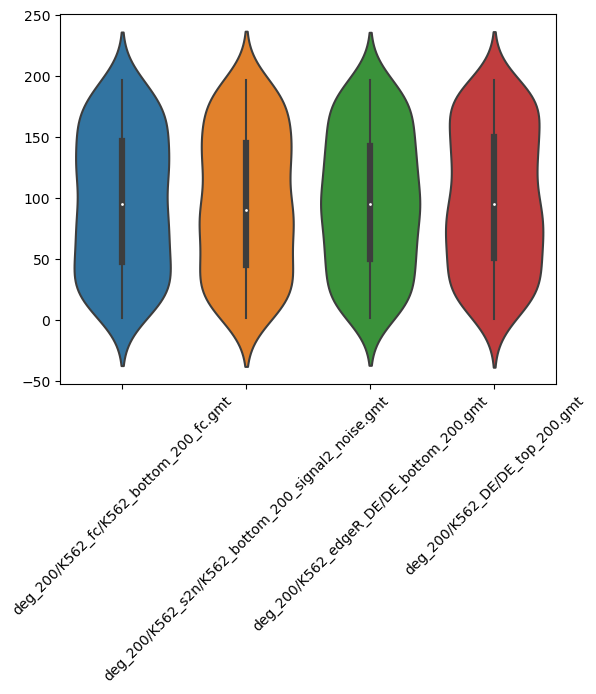

In [53]:
rank_df = pd.DataFrame.from_dict(rank_dict)
rank_df.transpose().to_csv('decoupler_results.control_Score.txt', sep='\t')
plt.xticks(rotation=45)
sns.violinplot(data=rank_df.transpose())